# Feature Visualization with GAN parameterization

![](..\images\GAN_parametrization_card.png)
**Author**: Binxu Wang 

**Created**: July 30th, 2020

**Updated** May 6th, 2021


This notebooks show the usage of more complex image priors / parametrizations like GANs to help feature visualization. 


In [41]:
from lucent.optvis.transform import pad, jitter, random_rotate, random_scale
from lucent.optvis import render, param, transform, objectives
from lucent.optvis.param.gan import upconvGAN
import torch
from torchvision import models
from torchvision import transforms
from imageio import imsave
from os.path import join
import numpy as np
import matplotlib.pylab as plt

import PIL.Image
from IPython.display import display

In [23]:
def make_grid_np(img_arr, nrow=8, padding=2, pad_value=0):
    """img_arr is a 4 dim np array consist of N images of the same sizes"""
    nmaps = img_arr.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(np.ceil(float(nmaps) / xmaps))
    height, width = int(img_arr.shape[1] + padding), int(img_arr.shape[2] + padding)
    grid = np.zeros((height * ymaps + padding, width * xmaps + padding, 3), dtype=img_arr.dtype)
    grid.fill(pad_value)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            grid[y * height + padding: (y + 1) * height, x * width + padding: (x + 1) * width, :] = img_arr[k,:,:,:]
            k = k + 1
    return grid

def show_in_grid(img_arr, nrow=8, padding=2, pad_value=0):
    """Display a grid of images in img_arr, """
    imgmtg = make_grid_np(img_arr, nrow=nrow, padding=padding, pad_value=pad_value)
    display(PIL.Image.fromarray((imgmtg*255).astype("uint8")))
    return imgmtg

Let's setup the networks, the generator is adopted from a GAN pretrained on ImageNet, s.t. it could invert the FC6 (or FC7 or pool5) representation of AlexNet.
The script will download the generative network automatically. 

In [2]:
VGG = models.vgg16(pretrained=True)
VGG.cuda();

In [3]:
G = upconvGAN("fc6")
G.requires_grad_(False)
G.cuda()
def GANparam(batch=1, sd=1):
    code = (torch.randn((batch, G.codelen)) * sd).to("cuda").requires_grad_(True)
    imagef = lambda:  G.visualize(code)
    return [code], imagef

  0%|          | 0.00/214M [00:00<?, ?B/s]

Let's look at the image quality of the generated images. To be honest, they are not especially object like. 

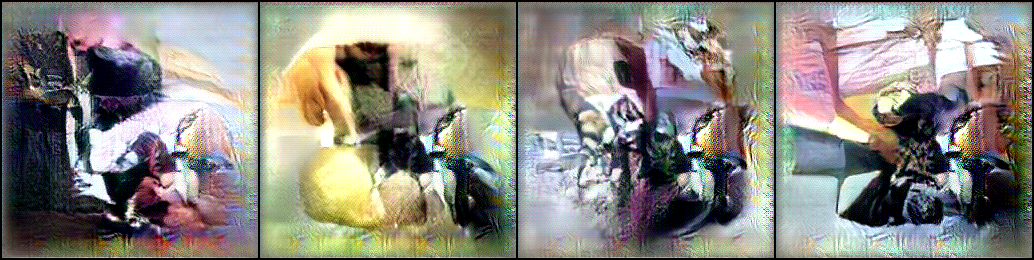

In [55]:
sd = 2 # sd control the standard deviation of the latent code, thus control the norm of it and the contrast of the image.
show_in_grid(G.visualize(sd*torch.randn((4, G.codelen)).cuda()).cpu().permute([0,2,3,1]).numpy());

Directly using GAN parametrization results in faster and still useful visualization, 40sec for 4 threads on a 1060 GPU. 

In [30]:
class_id = 949 # I hope you can guess the object class directly from the feature visualization
# class_id = 950 # Try this! 

  0%|▎                                                                                 | 1/256 [00:00<00:40,  6.35it/s]

Initial loss: 0.652


 25%|████████████████████▌                                                            | 65/256 [00:09<00:28,  6.61it/s]

Loss at step 64: -36.405


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:38<00:00,  6.69it/s]

Loss at step 256: -55.863


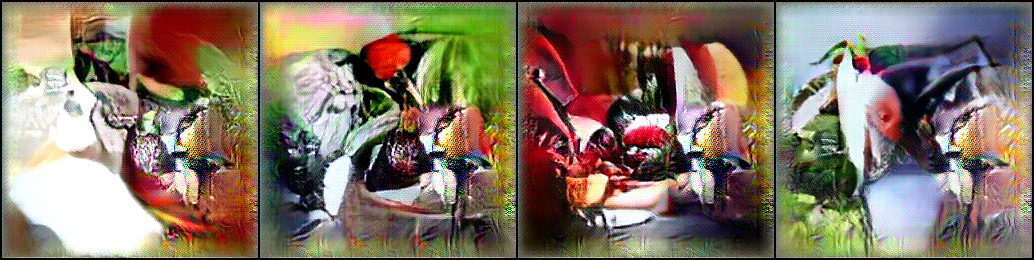

In [37]:
GANparam_f = lambda: GANparam(batch=4, sd=1)
GANopt = lambda params: torch.optim.Adam(params, 5e-2)  # 5E-2 looks good
obj = objectives.channel('classifier_6', n_channel=class_id, batch=None)  # optimizing the latent code
images = render.render_vis(VGG, obj, GANparam_f, GANopt, transforms=[], thresholds=(64, 256,), show_inline=False, verbose=True, show_image=False) # turn on verbose to see the optimization process
show_in_grid(images[-1]);

Adding transform robustness will make the feature visualization looks better. 

**Note** that it will lower the objective, comparing to the previous un-regularized optimization. One interpretation is that transform robustness prevent Generator from generating non-robust features to stimulate the target unit.

  0%|▎                                                                                 | 1/256 [00:00<00:51,  4.99it/s]

Initial loss: 0.625


 25%|████████████████████▌                                                            | 65/256 [00:12<00:37,  5.03it/s]

Loss at step 64: -19.609


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:51<00:00,  5.01it/s]

Loss at step 256: -43.624


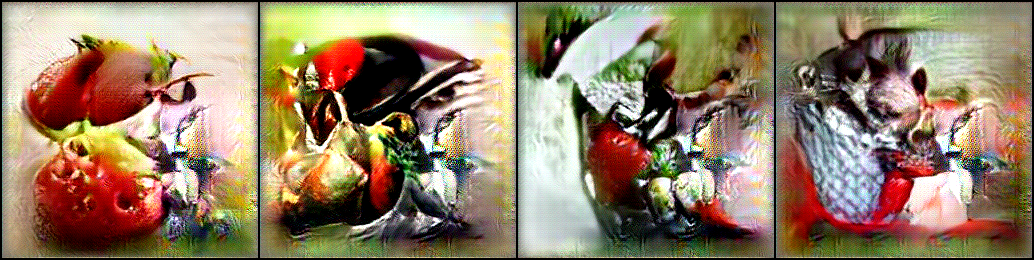

In [36]:
tfms = [pad(12, mode="constant", constant_value=.5),
        jitter(8),
        random_scale([1 + (i - 5) / 50. for i in range(11)]),
        random_rotate(list(range(-10, 11)) + 5 * [0]),
        jitter(4),]
GANparam_f = lambda: GANparam(batch=4, sd=1)
GANopt = lambda params: torch.optim.Adam(params, 5e-2)  # 5E-2 looks good
obj = objectives.channel('classifier_6', n_channel=class_id, batch=None)  # optimizing the
images = render.render_vis(VGG, obj, GANparam_f, GANopt, transforms=tfms, thresholds=(64, 256,), show_inline=False, verbose=True, show_image=False)
show_in_grid(images[-1]);

Add sample diversity to the objective should make the samples look more different. 

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Initial loss: 7.593


 25%|████████████████████▎                                                            | 64/256 [00:13<00:39,  4.91it/s]

Loss at step 64: -15.903


 50%|████████████████████████████████████████▎                                       | 129/256 [00:26<00:26,  4.86it/s]

Loss at step 128: -18.987


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:52<00:00,  4.89it/s]

Loss at step 256: -28.018


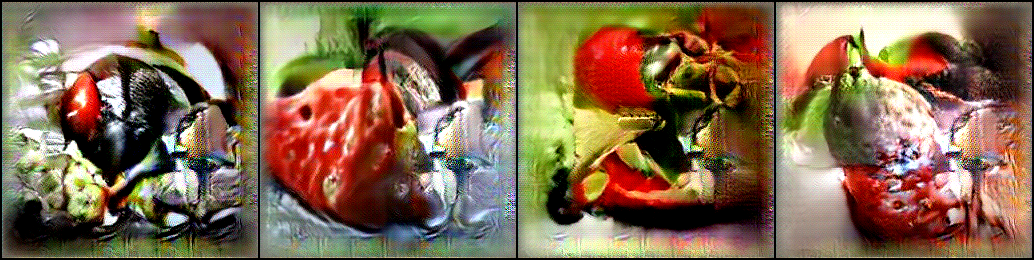

In [38]:
tfms = [pad(12, mode="constant", constant_value=.5),
        jitter(8),
        random_scale([1 + (i - 5) / 50. for i in range(11)]),
        random_rotate(list(range(-10, 11)) + 5 * [0]),
        jitter(4),]

GANparam_f = lambda: GANparam(batch=4, sd=1)
GANopt = lambda params: torch.optim.Adam(params, 5e-2)  # 5E-2 looks good
obj = objectives.channel('classifier_6', n_channel=class_id, batch=None) - .25e1 * objectives.diversity('features_15')  # optimizing the
images = render.render_vis(VGG, obj, GANparam_f, GANopt, transforms=tfms, thresholds=(64, 128, 256), show_inline=False, verbose=True, show_image=False)
show_in_grid(images[-1]);

Compare to the feature visualization using lower level prior / parametrizations: pixel parametrization and FFT parametrization. 

**Note** that, even with transform robustness, the lower level parametrization still could not match the feature interpretability of the GAN parametrization. But the scores of the objective is much higher than that of the GAN generated images, suggesting that pixel and FFT parametrized image could still leverage many non-robust features to stimulate the objective. 

  0%|▎                                                                                 | 2/512 [00:00<00:35, 14.22it/s]

Initial loss: -0.435


 13%|██████████▍                                                                      | 66/512 [00:07<00:50,  8.82it/s]

Loss at step 64: -109.517


 25%|████████████████████▎                                                           | 130/512 [00:15<00:43,  8.83it/s]

Loss at step 128: -174.532


 50%|████████████████████████████████████████▎                                       | 258/512 [00:31<00:28,  8.78it/s]

Loss at step 256: -235.889


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [01:01<00:00,  8.28it/s]

Loss at step 512: -196.386


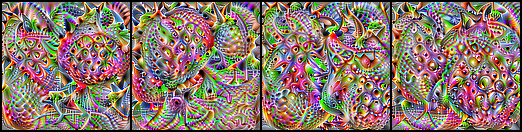

In [44]:
tfms = [pad(12, mode="constant", constant_value=.5),
        jitter(8),
        random_scale([1 + (i - 5) / 50. for i in range(11)]),
        random_rotate(list(range(-10, 11)) + 5 * [0]),
        jitter(4),]

param_f = lambda: param.image(128, fft=False, decorrelate=False, batch=4)
obj = objectives.channel('classifier_6', n_channel=class_id, batch=None)
images = render.render_vis(VGG, obj, param_f, transforms=tfms, thresholds=(64, 128, 256, 512), show_inline=False, verbose=True, show_image=False)
show_in_grid(images[-1]);

  0%|▎                                                                                 | 2/512 [00:00<00:36, 14.02it/s]

Initial loss: -1.527


 13%|██████████▍                                                                      | 66/512 [00:07<00:50,  8.90it/s]

Loss at step 64: -87.069


 25%|████████████████████▎                                                           | 130/512 [00:15<00:42,  8.88it/s]

Loss at step 128: -85.122


 50%|████████████████████████████████████████▎                                       | 258/512 [00:30<00:28,  8.88it/s]

Loss at step 256: -115.393


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [01:01<00:00,  8.35it/s]

Loss at step 512: -146.991


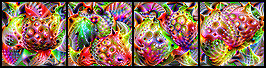

In [45]:
tfms = [pad(12, mode="constant", constant_value=.5),
        jitter(8),
        random_scale([1 + (i - 5) / 50. for i in range(11)]),
        random_rotate(list(range(-10, 11)) + 5 * [0]),
        jitter(4),]

param_f = lambda: param.image(64, fft=True, decorrelate=False, batch=4)
obj = objectives.channel('classifier_6', n_channel=class_id, batch=None)
images = render.render_vis(VGG, obj, param_f, transforms=tfms, thresholds=(64, 128, 256, 512), show_inline=False, verbose=True, show_image=False)
show_in_grid(images[-1]);